# 全局设置

In [1]:
# 加载必要的包
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.colors
import sys
sys.path.append("..")

# 自己写的，Pettitt方法检测时间序列断点
from tools.statistic import plot_pittitt_change_points, Pettitt_change_points, plot_slopes
from tools.statistic import ratio_contribution, plot_ratio_contribution
from tools.processing import get_position_by_ratio

In [2]:
# 绘图全局设置
# %config InlineBackend.figure_format ='retina'
import matplotlib.colors as col
from matplotlib.gridspec import GridSpec
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'out'

period_colors = ['#0889A6', '#F1801F', '#006C43']
region_colors = ["#0077b6", "#e07a5f", "#f2cc8f","#81b29a"]
index_colors = ['#CFA7D1', '#79D6F0', '#E25A53']
index_colormap = matplotlib.colors.ListedColormap(index_colors, 'indexed')
total_water_use_color = '#D1495B'

# 非直接用水比例

## 方法介绍

间接用水比例（Indirect Proportion of Water Use, IPWU），用于描述被消耗的水资源中，以间接形式惠益于人类的部分。

计算方法：
$$ IPWU_{ij} = \frac{WU_{indirect, i, j}}{WU_{direct, i, j} + WU_{undirect, i, j}} $$

其中i是年份，j是计算区域，indirect和direct分别是为人类间接带来惠益的取用水方式和带来直接惠益取用水方式

indirect包括： 
- 工业用水量（IND），每年用于工业目的的取水量，包括自给自足的工业和与公共供水网络连接的工业。
- 城市服务业用水量（Urban service WU），指公共供水网络每年用于服务活动的直接用水量。

direct包括：
- 农业灌溉用水总量（IRR）：每年抽取的灌溉用水量，包括运输和田间施用期间的损失，但不包括牧场或水产养殖用水
- 城市居民用水（Urban domestic WU）：公共供水网络每年用于城镇居民直接取水的水量
- 农村居民用水（Rural domestic WU）：公共供水网络每年用于农村居民和牲畜直接使用的取水量
- 农村牲畜用水（Rural livestock WU）：公共供水网络用于牲畜饮水和清洁的年度取水量

In [3]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv('../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv')

# 产生直接惠益的用水方式
direct = ['IRR', 'Urban domestic WU', 'Rural domestic WU', 'Rural livestock WU']

# 产生间接惠益的用水方式
undirect = ['IND', 'Urban service WU']

# 间接用水量
undirect_water_use = city_yr.groupby('Year').sum()[undirect]

# 总用水量
total_water_use = city_yr.groupby('Year').sum()['Total water use']
 
# 整个流域的间接惠益用水占比
ipwu = undirect_water_use.sum(axis=1) / total_water_use

# 计算贡献
undirect_water_use.columns = ["Industry", "Service"]
ipwu_contributions = ratio_contribution(numerator=undirect_water_use, denominator=total_water_use)

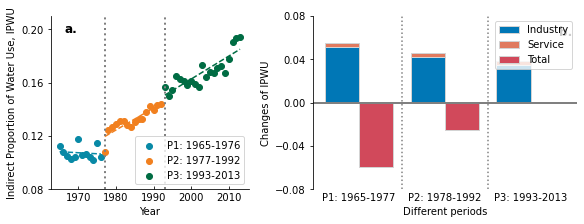

In [4]:
# 绘图
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘制图1
plot_pittitt_change_points(ipwu, change_points=[1977, 1993], ax=ax1, colors=period_colors)

# 绘制图2
plot_ratio_contribution(ipwu_contributions,
                        ax=ax2,
                        colors=region_colors,
                        denominator_color=total_water_use_color,
                        denominator_label='Total')

# 修饰图1
ax1.set_ylabel("Indirect Proportion of Water Use, IPWU")
ax1.set_xlabel("Year")
ax1.set_yticks(np.arange(0.08, 0.21, 0.04))
ax1.set_ylim(0.08, 0.21)
ax1.text(1968, 0.2, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of IPWU")
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax2.axhline(0., lw=2, color='gray')
ax2.set_ylim(-0.08, 0.08)
ax2.set_yticks(np.arange(-0.08, 0.081, 0.04))
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
ax2.text(2.4, 0.065, 'b.', ha='center', va='center', weight='bold', size='large')

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)

# 出图
plt.show();

# 配水指数

## 方法介绍

模仿熵的公式，我们设计了一个衡量分配平均度的指标“配水指数(Water Distribution Index, WDI)”。我们假设最平均的水分配情况是，为每个行政区域某个部门分配到的用水量，都等于全流域该部门的平均用水比例。但实际上区域有别，有的区域会更集中发展某个用水部门，这就导致了水的分配不够平均，使得分配熵增大。而实际的分配情况与假设的平均分配情况，即为配水指数WDI，**WDI越大代表分配越平均，越小代表分配越不均匀**

![](https://gitee.com/SongshGeo/PicGo_picbed/raw/master/img/diagram_water_distribution_index.jpg)

例如在上图中，左边展示的是假设的区域间均匀分配的情况。后者则是实际中分工各有差异，发展各有先后的情况。

$$ WDI = \frac{Entropy}{Entropy_{max}} $$

$$ Entropy = \sum_{i=1}^n \sum_{j=1}^m -log(p_{ij}) * p_{ij} $$

$$ Entropy_{max} = n * \sum_{j=1}^m -\frac{p_j}{n} * log(\frac{p_j}{n}) $$ 

$$ p_j = \frac{\sum_{i=1}^n WU_j}{\sum_{i=1}^n WU} $$

$$ p_{ij} = \frac{WU_{ij}} {\sum_{i=1}^n \sum_{j=1}^m WU_{ij}} $$

**where:**

j = 1, .. m representing different water use sections (IRR, IND, RUR, URB).

j 代表了不同的用水部门（农业灌溉、工业用水、农村牲畜用水、农村生活用水、城市生活用水、城市服务业用水），因此 $ m = 6 $。

i = 1, ... n, representing different regions.
其中x是可供分配的区域数量，在这里我们使用统一的划分（源区SR，上游UR，中游MR，下游DR），因此 $ n = 4 $。

## 计算指数 a/b

$$ WDI = \frac{H_{region}}{H_{region, uniformly}} / \frac{H_{section}}{H_{section, uniformly}} $$

In [5]:
# 各区域每年的总用水
wu_cols = ['IRR', 'IND', 'DOM']

city_yr['DOM'] = city_yr['RUR'] + city_yr['URB']

region_consumption = city_yr.groupby(['Year', 'Region'])[wu_cols].sum()

results = {}
for yr in city_yr['Year'].unique():
    data = region_consumption.loc[yr].replace(0., 0.0000000001)
    
    region_p = data.sum(axis=1) / data.sum().sum()
    region_entropy =  np.sum(- region_p * np.log(region_p))
    region_max_entropy = data.shape[0] * (-1/data.shape[0] * np.log(1/data.shape[0]))
    region_index = region_entropy / region_max_entropy
    
    section_entropy = data.apply(lambda row: row/row.sum(), axis=0).apply(lambda row: row.apply(lambda p: -p*np.log(p)).sum(), axis=1).mean()
    # 对每个区域：将各部门的用水量换算成比率 p，计算每个区域不同用水部门之间分配的熵，再取各个区域的均值
    section_max_p = data.sum() / data.sum().sum()
    section_max_entropy = section_max_p.apply(lambda p: -p*np.log(p)).sum()
    section_index = section_entropy / section_max_entropy
    
    section_2_p = data / data.sum()
    section_2_entropy = (-section_2_p*np.log(section_2_p)).sum().mean()
    
    ratio = region_entropy / section_entropy
    index_ratio = region_index / section_index
    
    index_ratio_2 = region_entropy / section_2_entropy 
    
    results[yr] = {
        'Regions': region_entropy,
        'Divisions': section_entropy,
        'Sectors': section_max_entropy,
        'Ratio': index_ratio,
    }
    
index_result = pd.DataFrame(results).T

entropy_contributions = ratio_contribution(numerator=index_result[['Sectors', 'Regions']], denominator=index_result['Divisions']*region_max_entropy)

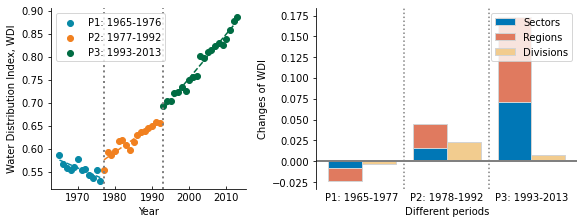

In [6]:
# 绘图
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘图ax1
wdi_slopes = plot_pittitt_change_points(index_result['Ratio'], change_points=[1977, 1993], ax=ax1, colors=period_colors)
# 绘图ax2
plot_ratio_contribution(entropy_contributions, denominator_color=region_colors[2], denominator_label="Divisions", ax=ax2)

# 修饰图1
ax1.set_ylabel("Water Distribution Index, WDI")
ax1.set_xlabel("Year")
# ax1.set_yticks(np.arange(0.28, 0.62, 0.10))
# ax1.set_ylim(0.28, 0.64)
# ax1.text(1998, 0.60, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of WDI")
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax2.axhline(0., lw=2, color='gray')
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
# ax2.text(2.4, 0.140, 'b.', ha='center', va='center', weight='bold', size='large')

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)

# 出图
plt.show();

# SFV结构性缺水指数

## 方法介绍

人类利用科技手段不断的管理水资源，因此简单的物理缺水指数无法合理评估结构性水资源短缺在社会-水系统演化与过渡中所起的作用。因此，我们参考 Qin et al., 2019中提出的结构性缺水指数来评价流域缺水。该指数考虑了修建水库等管理措施，以及用水结构变化对水资源短缺情况评价的影响。

利用该方法计算SFV指数，需要考虑三方面指标：

- 首先是总的耗水量占区域多年平均径流量的比例：
$$ A_{i, j} = \frac{WU_{i,j}}{R_{i, avg}} $$

其中平均径流量用如下公式计算：
$$ R_{i, avg} = \frac{1}{j} * \sum_{j=1}^j R_{i} $$

- 其次是非弹性用水量占多年平均径流量的比例：
$$ B_{i, j} = \frac{WU_{inflexible}}{R_{i, avg}} $$

对于非弹性用水，Qin在文章中给出了如下划分：
For inflexible consumption, we include (according to Qin et al., 2019):    
- (1) Freshwater consumed for irrigation of perennial crops.
- (2) Water  evaporated during cooling of thermal power plants. √
- (3) Water evaporated from reservoirs.
- (4) Basic water allotments for humans and livestock. √

由于数据限制，本研究中，取其中（2）、（4）的和为非弹性用水。

- 最后，还要考虑水库的库容能力及调蓄作用对应对天然径流波动的积极影响：
$$ C1_{i, j} = \frac{R_{i, std}}{R_{i, avg}} $$

$$ C2_{i} = \frac{RC_{i}}{R_{i, avg}}, \ if RC < R_{i, avg} $$

$$ C2_{i} = 1, \ if RC >= R_{i, avg} $$

$$ C_i = C1_i * (1 - C2_i) $$

其中$RC_i$是该区域的水库总库容，$R_{i, std}$是多年径流的标准差，衡量天然径流的波动。

取三个要素的权重相等，标准化后计算SFV指数：

$$ V = \frac{A_{normalize} + B_{normalize} + C_{normalize}}{3} $$
$$ a = \frac{1}{V_{max} - V_{min}}; $$
$$ b = \frac{1}{V_{min} - V_{max}} * V_{min} $$

（注：原文献中使用的常数为100，得到的指数结果位于$0~100$之间，这里为了和其余两指数保持$0~1$的相同数量级，将该系数调整为1）

Qin, Y. et al. Flexibility and intensity of global water use. Nature Sustainability 2, 515–523 (2019).

In [7]:
# 加载径流和水库数据
use_cols = {
    '唐乃亥': 'SR',  # 唐乃亥控制源区
    '头道拐': 'UR',  # 头道拐控制上游
    '花园口': 'MR',  # 花园口控制中游
    '利津': 'DR'     # 利津控制下游
}
measured_runoff = pd.read_csv(r'../data/hydrology/1956-2016_runoff.csv', index_col='年份')
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

In [8]:
# 水库库容数据
reservoirs_capacity = pd.read_csv(r'../data/hydrology/cum_reservoirs.csv',
                                  index_col=0)

# 水库库容累积相加数据
reservoirs_capacity_cumulating = reservoirs_capacity.cumsum()

In [9]:
## 提取非灵活用水的数据

# 与基本信息有关的列
use_cols = ['Year', 'Region', 'City_ID']

# 与耗水量有关的列
wu_cols = [
    'Total water use',
    'IRR', 'IND', 'RUR', 'URB', 
    'Urban domestic WU', 'Rural domestic WU', 
    'Rural livestock WU', 'Urban service WU',
    'Industrial gross value added (GVA): Thermal electrivity',
    'Industrial WUI: Thermal electrivity'
]

# 不具备弹性的用水类别
inflexible_wu = [
    'Urban domestic WU',
    'Rural domestic WU',
    'Rural livestock WU',
    'Thermal WU'  # 需要用 Thermal 的 WUI 和 GVA 相乘进行计算
]

use_cols.extend(wu_cols)  # 在计算SFV中所有使用的数据列

# 加载所有使用的数据
consumptions = city_yr[use_cols].copy()

# 计算火电冷却用水的量
consumptions['Thermal WU'] = consumptions['Industrial gross value added (GVA): Thermal electrivity'] * consumptions['Industrial WUI: Thermal electrivity']
consumptions.drop(wu_cols[-2:], axis=1, inplace=True)  # 删除计算后的 WUI, GVA 数据

for col in consumptions.columns:
    if col in wu_cols or col in inflexible_wu:
        consumptions[col] = consumptions[col] * 10   # 转化单位 km3 → 10^8 m3

consumptions.head()

,Year,Region,City_ID,Total water use,IRR,IND,RUR,URB,Urban domestic WU,Rural domestic WU,Rural livestock WU,Urban service WU,Thermal WU
0,1965,UR,C27,3.285860,3.005177,0.117663,0.090214,0.072806,0.053977,0.058185,0.032029,0.018829,0.004365
1,1966,UR,C27,3.519960,3.235953,0.119966,0.090686,0.073354,0.054876,0.057330,0.033356,0.018478,0.003637
2,1967,UR,C27,3.724324,3.400632,0.172264,0.080629,0.070799,0.053929,0.046496,0.034134,0.016870,0.010638
3,1968,UR,C27,3.914576,3.526895,0.224933,0.088092,0.074656,0.056472,0.053221,0.034871,0.018184,0.015332
4,1969,UR,C27,4.061363,3.657395,0.197515,0.120128,0.086325,0.063396,0.084373,0.035755,0.022929,0.008404


## 计算三部分指数

In [10]:
## 计算三个部分的指数

# A 总耗水量 / 平均多年径流量
total_water_use = consumptions.groupby(['Region', 'Year']).sum()['Total water use']

regions = ['SR', 'UR', 'MR', 'DR']

index_a = pd.DataFrame()
for region in regions:
    a = total_water_use.loc[region] / measured_runoff.mean(axis=0)[region]
    index_a[region] = a
    
    
# B 总不灵活耗水量 / 平均多年径流量
inflexible_water_use = consumptions.groupby(['Region', 'Year']).sum()[inflexible_wu].sum(axis=1)

index_b = pd.DataFrame()
for region in regions:
    b = inflexible_water_use.loc[region] / measured_runoff.mean(axis=0)[region]
    index_b[region] = b
    
# C1
index_c1 = measured_runoff.std() / measured_runoff.mean()

# C2
index_c2 = pd.DataFrame()
for region in regions:
    avg_runoff = measured_runoff[region].mean()
    c2 = reservoirs_capacity_cumulating[region].apply(lambda x: x/avg_runoff if x < avg_runoff else 1)
    index_c2[region] = c2
    
# C
index_c = (1-index_c2) * index_c1

## 标准化

In [11]:
# 标准化数据
def normalization_horizontal(data):
    sfv = pd.DataFrame(columns=[regions])
    for row in data.itertuples():
        year = row[0]
        value = np.array(row[1:])
        avg = np.mean(value)
        std = np.std(value)
        sfv.loc[year] = (value - avg) / std
    return sfv


# 新建空的 sfv_index 数据框，准备存储数据
use_years = city_yr['Year'].unique()
v_values = np.zeros(index_a.shape)
for index in [index_a, index_b, index_c]:
    index = normalization_horizontal(index.loc[use_years].copy())
    v_values += index.values / 3
    

# 将V-values使用 SFV = a * V + b 转化为 SFV_index
sfv_values = []
for v_row in v_values:
    a = 1 / (v_row.max() - v_row.min())
    b = 1 * v_row.min() / (v_row.min() - v_row.max())
    sfv = a * v_row + b
    sfv_values.append(sfv)

# 计算区域的SFV指数
sfv_regions = pd.DataFrame(sfv_values, columns=regions, index=use_years)

# 计算全域的平均SFV指数
sfv = pd.Series(np.array(sfv_values).mean(axis=1), index=use_years)

## 非灵活用水占比

In [12]:
inflexible_water_use = consumptions.groupby(['Year']).sum()[inflexible_wu]
inflexible_water_use_sum = inflexible_water_use.sum(axis=1)
total_water_use = consumptions.groupby(['Year']).sum()['Total water use']

# 非灵活用水占比
inflexible_ratio = inflexible_water_use_sum / total_water_use

# 非灵活用水贡献
inflexible_contributions = ratio_contribution(numerator=inflexible_water_use, denominator=total_water_use)

## SFV的三部分贡献

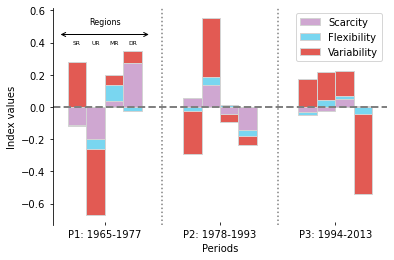

In [13]:
def get_index_yr(start_yr, end_yr):
    differences = []
    for index in [index_a, index_b, index_c]:
        data = normalization_horizontal(index)
        differences.append((data.loc[end_yr] - data.loc[start_yr])/3)
    return differences

sfv_contribution = pd.DataFrame()
sfv_contribution = sfv_contribution.append(get_index_yr(1965, 1977))
sfv_contribution = sfv_contribution.append(get_index_yr(1978, 1993))
sfv_contribution = sfv_contribution.append(get_index_yr(1994, 2013))

# ================================== 作图 =============================
fig, ax = plt.subplots()

def sfv_contribution_plot(ax):
    width = 0.16
    alpha = 1
    for i in range(3):
        data = sfv_contribution.iloc[i*3:i*3+3]  # 数据
        period = "P{}".format(i+1)  # 哪个阶段
        bottoms_pos = [0, 0, 0, 0]  # 正方向的底
        bottoms_neg = [0, 0, 0, 0]  # 反方向的底
        for j, row in enumerate(data.itertuples(index=False)):
            index = ["Scarcity", "Flexibility", "Variability"][j]
            color = ['#CFA7D1', '#79D6F0', '#E25A53'][j]
            for d, height in enumerate(row):
                region = ['SR', 'UR', 'MR', 'DR'][d]
                position = i - 1.5 * width + d * width
                if j == 0 and i == 0:
                    ax.text(position, 0.4, region, size=6, va="center", ha="center")
                if height >= 0:
                    bottom = bottoms_pos[d]
                    if d == 1 and i == 1:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray', label=index)
                    else:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray')
                    bottoms_pos[d] += height
                else:
                    bottom = bottoms_neg[d]
                    if d == 1 and i == 1:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray', label=index)
                    else:
                        ax.bar(x=position, height=height, bottom=bottom, width=width, color=color, alpha=alpha, edgecolor='lightgray')
                    bottoms_neg[d] += height
    ax.legend()
    ax.axhline(y=0, ls="--", lw=2, color='gray')
    ax.axvline(1.5, ls=':', color='gray')
    ax.axvline(0.5, ls=':', color='gray')
    ax.set_ylabel("Index values")
    ax.set_xticks(np.arange(0, 2.1, 1))
    ax.set_xlabel("Periods")
    ax.set_xticklabels(["P1: 1965-1977", "P2: 1978-1993", "P3: 1994-2013"])

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)

    ax.text(0, 0.5, "Regions", va='bottom', ha='center', size=8)
    ax.annotate("", xy=(-0.4, 0.45), xycoords='data',
             xytext=(0.4, 0.45), textcoords='data',
             arrowprops=dict(arrowstyle="<->",
                             connectionstyle='arc3'))

sfv_contribution_plot(ax)
plt.show();

### 非灵活用水贡献

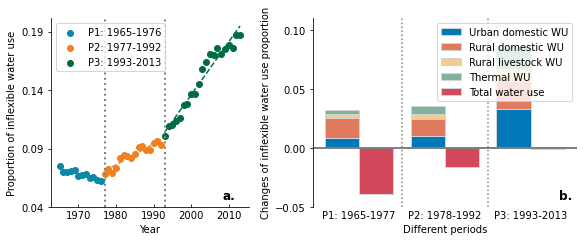

In [14]:
# 绘图
fig = plt.figure(figsize=(8, 3.25), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# 绘制图片 1
inflexible_slopes = plot_pittitt_change_points(inflexible_ratio, change_points=[1977, 1993], colors=period_colors, ax=ax1)

# 绘制图片 2
plot_ratio_contribution(inflexible_contributions, denominator_color=total_water_use_color, denominator_label='Total water use', ax=ax2)

# 修饰图片 1
ax1.set_xlabel("Year")
ax1.set_ylabel("Proportion of inflexible water use")
ax1.set_yticks(np.arange(0.04, 0.20, 0.05))
ax1.legend(loc=2)
ax1.text(2010, 0.05, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图片 2
ax2.set_xlabel("Different periods")
ax2.set_ylabel("Changes of inflexible water use proportion")
ax2.axvline(1.5, ls=':', color='gray', lw=1.5)
ax2.axvline(0.5, ls=':', color='gray', lw=1.5)
ax2.axhline(0., lw=2, color='gray')
ax2.set_yticks(np.arange(-0.05, 0.11, 0.05))
ax2.set_ylim(-0.05, 0.11)
ax2.text(2.4, -0.04, 'b.', ha='center', va='center', weight='bold', size='large')
ax2.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)

# 调整坐标轴显示
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# 出图
plt.savefig('../figures/sup/inflexible_wu.pdf', dpi=300)
plt.savefig('../figures/sup/inflexible_wu.jpg', dpi=300)
plt.show();

# 黄河流域的综合耦合指数

流域综合耦合指数(Watershed Composite Coupling Index, WCCI)由三个0-1之间的指数（分别是：描述区域间水资源分配情况的用水分配指数 WDI；对人类产生间接惠益的取用水量比例（Indirect Proportion of Water Use, IPWU）；描述结构性缺水状况的指数 SFV）构成。可以综合反映流域内社会与水资源耦合的紧密程度：

$$ HWCI \propto IPWU $$
$$ HWCI \propto WDI $$ 
$$ HWCI \propto SFV^{-1} $$

## 计算耦合指数

$$ HWCI \propto IPWU * SFV^{-1} * WDI  $$
$$ ln(HWCI) = ln(IPWU) + ln(WDI) - ln(SFV) $$

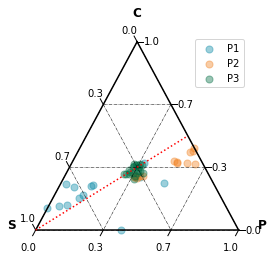

In [15]:

# 计算全域耦合指数
def zscore(x):
    return (x-x.min())/(x.max()-x.min())

wdi = index_result['Ratio']

z_ipwu, z_wdi, z_sfv = zscore(np.log(ipwu)), zscore(np.log(wdi)), zscore(np.log(sfv))
# z_ipwu, z_wdi, z_sfv = np.log(zscore(ipwu)), np.log(zscore(wdi)), np.log(zscore(sfv))

# 计算WCCI指数
wcci_log = z_ipwu + z_wdi - z_sfv  # wcci_log 是三者的 z_score 相加再相减
wcci = ipwu * wdi / sfv

# 制作三元图
points = []
points_1, points_2, points_3 = [], [], []
size_1, size_2, size_3 = [], [], []
scale = 50
for yr in wdi.index:
    sumed = z_ipwu[yr] + z_wdi[yr] + z_sfv[yr]  # 这里点的大小是三者 z_score 相加
    point = (z_ipwu[yr]/sumed, z_wdi[yr]/sumed, z_sfv[yr]/sumed)
    points.append(point)
    if yr < 1978:
        points_1.append(point)
        size_1.append(sumed * scale)
    elif yr < 1993:
        points_2.append(point)
        size_2.append(sumed * scale)
    else:
        points_3.append(point)
        size_3.append(sumed * scale)

# 如果没有ternary包，就 uncommand 下面一行进行安装
# pip install python-ternary
import ternary
fig, ax = plt.subplots(figsize=(4, 4))
figure, tax = ternary.figure(ax=ax, scale=1)
tax.boundary()
tax.gridlines(ls="-.", multiple=1./3, color="black")
# Plot a few different styles with a legend
tax.scatter(points_1, marker='o', color=period_colors[0], label="P1", s=scale, alpha=.4)
tax.scatter(points_2, marker='o', color=period_colors[1], label="P2", s=scale, alpha=.4)
tax.scatter(points_3, marker='o', color=period_colors[2], label="P3", s=scale, alpha=.4)
# tax.plot(points, ls=':', lw='0.7')   # 各点之间的连接线
fontsize = 12
offset = 0.15

tax.ticks(axis='brl', multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
# tax.ticks(axis='l', clockwise=True, multiple=1./3, linewidth=1, tick_formats="%.1f", offset=0.03)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()

def get_point(yr):
    a = z_ipwu[yr] + z_wdi[yr] - z_sfv[yr]
    return (z_ipwu[yr]/a, z_wdi[yr]/a, z_sfv[yr]/a)

tax.set_axis_limits((0,1))
tax.line((0,0,1),(.5,.5,0), ls=":", color='red')
tax.right_corner_label("P", fontsize=fontsize, offset=0.25, weight='bold')
tax.top_corner_label("C", fontsize=fontsize, offset=0.25, weight='bold')
tax.left_corner_label("S", fontsize=fontsize, offset=0.25, weight='bold')

tax.legend()
tax.show()
tax.savefig("../figures/main/phases.jpg", dpi=300)
tax.savefig("../figures/main/phases.pdf", dpi=300);

In [16]:
wcci.loc[1965:1978].mean()
wcci.loc[1979:1994].mean()
wcci.loc[1995:2013].mean()

0.10217519335440418

0.14435430924668832

0.19641741020592193

In [17]:
pd.DataFrame(points_3).mean(axis=0)

0    0.329116
1    0.318723
2    0.352160
dtype: float64

## 计算贡献度


分解分析法计算每个子指标对全域耦合指数在各个阶段的贡献度，首先将WCCI的计算公式两边取对数，得：

$$ ln(WCCI) = ln(IPWU) + ln(WDI) - ln(SFV) $$

对每个起始年份为$i$，截止年份为$j$的时间段，有：

$$ \Delta WCCI = WCCI_j - WCCI_i $$

即：

$$ ln(WCCI_j) - ln(WCCI_i) = ln(\frac{IPWU_j}{IPWU_i}) + ln(\frac{WDI_j}{WDI_i}) + ln(\frac{SFV_i}{SFV_j}) $$

以上式计算每个部分对WCCI变化量的贡献度

In [18]:
# 计算每个阶段的贡献度

def calculate_contributions(datasets, log=False):
    """这里Datasets应该是一个数据集字典：{'Tendentiousness', 'Pattern', 'Stress'}"""
    index_list = ['Tendentiousness', 'Pattern', 'Stress']  # 数据集字典的键
    
    # 用于储存贡献率计算结果的字典
    contribution = {index: [] for index in index_list}
    
    # 用于储存时间段划分的空列表
    periods = []
    changes = {}  # 储存每个时间段的变化
    
    # 从数据集中取出数据
    ipwu, wdi, sfv = [datasets[key] for key in index_list]
    
    # 计算综合指数并利用 Pettitt 方法寻找断点
    wcci = ipwu * wdi / sfv
    wcci_log = zscore(ipwu) + zscore(wdi) - zscore(sfv)
    if log:
        breakpoints = Pettitt_change_points(wcci_log)
    else:
        breakpoints = Pettitt_change_points(wcci)
    change_points = breakpoints.copy()
    change_points.extend([wcci.index.max(), wcci.index.min()])  # 为断点增加头尾
    check_points = sorted(change_points.copy())  # 排序好的断点列表作为检查点
    
    # 循环，每两个断点之间算一个阶段，计算每个阶段不同指数的贡献率。
    for i in range(len(check_points)-1):
        j = i + 1
        start_year = check_points[i]
        end_year = check_points[j]
        if end_year in breakpoints:
            end_year = end_year - 1
        period = 'P{}: {}-{}'.format(j, start_year, end_year)
        periods.append(period) # 每个阶段的标准化格式
        
        if log:
            changes[period] = abs(wcci_log.loc[end_year] - wcci_log.loc[start_year])
        else:
            changes[period] = wcci.loc[end_year] - wcci.loc[start_year]
        
        # 计算 WCCI 总的变化
        wcci_change = np.log(wcci[end_year]) - np.log(wcci[start_year])
        wcci_log_change = wcci_log[end_year] - wcci_log[start_year]
        
        # 再计算三个分指标的变化
        ipwu_change = np.log(ipwu.loc[end_year] / ipwu.loc[start_year])
        wdi_change = np.log(wdi.loc[end_year] / wdi.loc[start_year])
        sfv_change = np.log(sfv.loc[start_year] / sfv.loc[end_year])
        
        ipwu_log_change = zscore(ipwu)[end_year] - zscore(ipwu)[start_year]
        wdi_log_change = zscore(wdi)[end_year] - zscore(wdi)[start_year]
        sfv_log_change = zscore(sfv)[start_year] - zscore(sfv)[end_year]
        
        # 计算变化的贡献率并存入结果字典
        if log:  # 如果使用log线性模型标准化
            contribution['Tendentiousness'].append(100 * ipwu_log_change / abs(wcci_log_change))
            contribution['Pattern'].append(100 * wdi_log_change / abs(wcci_log_change))
            contribution['Stress'].append(100 * sfv_log_change / abs(wcci_log_change))
        else:
            contribution['Tendentiousness'].append(100 * ipwu_change / wcci_change)
            contribution['Pattern'].append(100 * wdi_change / wcci_change)
            contribution['Stress'].append(100 * sfv_change / wcci_change)
    
    # 将结果转化为 DataFrame 并返回
    contribution = pd.DataFrame(contribution, index=periods)
    return contribution, changes


# 将所有指数整合进一个数据集字典
index_results = {
    'WCCI': wcci,
    'Tendentiousness': ipwu,
    'Pattern': wdi,
    'Stress': sfv
}

# 调用函数计算贡献度
contribution, changes = calculate_contributions(index_results, log=True)
contribution
changes

,Tendentiousness,Pattern,Stress
P1: 1965-1977,-8.279972,-15.833382,124.113354
P2: 1978-1993,8086.440208,6414.601129,-14601.041336
P3: 1994-2013,73.906078,78.536238,-52.442316


{&#39;P1: 1965-1977&#39;: 0.5821481092032936,
 &#39;P2: 1978-1993&#39;: 0.0043544754472097935,
 &#39;P3: 1994-2013&#39;: 0.656236874310058}

In [19]:
# 各个指数对 WCCI 在每个阶段发生变化的贡献量

changes_contribution = pd.DataFrame()

for col in contribution:
    changes_contribution[col] = contribution[col] * pd.Series(changes) / 100
    
print("第三阶段 WDI 的贡献是较第二阶段增长的倍数：")
changes_contribution['Pattern'].iloc[2] / changes_contribution['Pattern'].iloc[1] - 1

print("第三阶段 IPWU 的贡献是较第二阶段增长的倍数：")
changes_contribution['Tendentiousness'].iloc[2] / changes_contribution['Tendentiousness'].iloc[1] - 1

print("第三阶段 SFV 的贡献是较第二阶段增长的倍数：")
changes_contribution['Stress'].iloc[2] / changes_contribution['Stress'].iloc[1] - 1

第三阶段 WDI 的贡献是较第二阶段增长的倍数：


0.8451225602945083

第三阶段 IPWU 的贡献是较第二阶段增长的倍数：


0.3773603031317043

第三阶段 SFV 的贡献是较第二阶段增长的倍数：


-0.458718959715979

## 最终作图

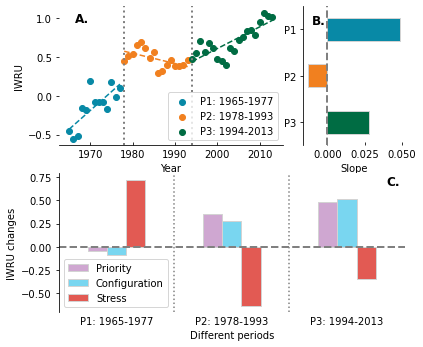

In [20]:
# 绘图
fig = plt.figure(constrained_layout=False, figsize=(6, 5))
fig.subplots_adjust(left=0.15, right=0.95, top=.95, bottom=.10)

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])

wcci_slopes = plot_pittitt_change_points(wcci_log, ax=ax1, colors=period_colors)
plot_slopes(wcci_slopes, ax=ax2, colors=period_colors)
changes_contribution.columns = ['Priority', 'Configuration', 'Stress']
changes_contribution.plot.bar(ax=ax3, colormap=index_colormap, edgecolor='lightgray')

# 修饰图片1
ax1.set_xlabel('Year')
ax1.set_ylabel('IWRU')
# ax1.set_ylim(0.04, 0.105)
# ax1.set_yticks(np.arange(0.04, 0.105, 0.02))
ax1.text(1968, 1.0, 'A.', ha='center', va='center', weight='bold', size='large')
ax1.legend(loc=4)

# 修饰图片2
ax2.set_xlabel("Slope")
# ax2.set_xticklabels([.0, .5, 1])
ax2.text(-0.006, 2.2, 'B.', ha='center', va='center', weight='bold', size='large')

# 修饰图片3
ax3.set_xlabel("Different periods")
ax3.set_ylabel('IWRU changes')
for tick in ax3.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转
ax3.axhline(y=0, c='gray', lw=2, ls="--")
# ax3.set_yticks(np.arange(-0.01, 0.021, 0.01))
ax3.tick_params(axis='x', tickdir='in', bottom=False, labelrotation=0)
ax3.text(2.4, 0.7, 'C.', ha='center', va='center', weight='bold', size='large')
ax3.axvline(1.5, ls=':', color='gray')
ax3.axvline(0.5, ls=':', color='gray')

# 调整坐标轴显示
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)

ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(False)

# 储存和显示图片
plt.savefig('../figures/main/index.pdf', dpi=300)
plt.savefig('../figures/main/index.jpg', dpi=300)
plt.show();

In [21]:
changes_contribution
for index in ["Stress", "Priority", "Configuration"]:
    index
    changes_contribution[index] / changes_contribution.sum(axis=1)

print("如果算贡献率的话：")
for index in ["Stress", "Priority", "Configuration"]:
    index
    changes_contribution[index].abs() / changes_contribution.abs().sum(axis=1) 

,Priority,Configuration,Stress
P1: 1965-1977,-0.048202,-0.092174,0.722524
P2: 1978-1993,0.352122,0.279322,-0.635799
P3: 1994-2013,0.484999,0.515384,-0.344146


&#39;Stress&#39;

P1: 1965-1977      1.241134
P2: 1978-1993    146.010413
P3: 1994-2013     -0.524423
dtype: float64

&#39;Priority&#39;

P1: 1965-1977    -0.082800
P2: 1978-1993   -80.864402
P3: 1994-2013     0.739061
dtype: float64

&#39;Configuration&#39;

P1: 1965-1977    -0.158334
P2: 1978-1993   -64.146011
P3: 1994-2013     0.785362
dtype: float64

如果算贡献率的话：


&#39;Stress&#39;

P1: 1965-1977    0.837321
P2: 1978-1993    0.501718
P3: 1994-2013    0.255960
dtype: float64

&#39;Priority&#39;

P1: 1965-1977    0.055860
P2: 1978-1993    0.277865
P3: 1994-2013    0.360720
dtype: float64

&#39;Configuration&#39;

P1: 1965-1977    0.106819
P2: 1978-1993    0.220417
P3: 1994-2013    0.383319
dtype: float64

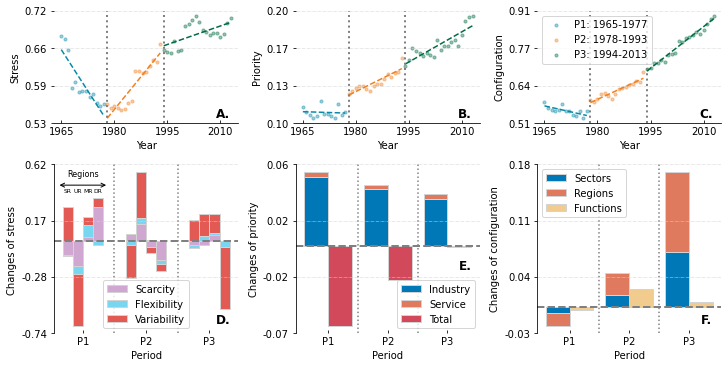

In [22]:
fig = plt.figure(figsize=(10, 5), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=[2, 3])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])


import matplotlib.ticker as ticker
size = 10
alpha= 0.4

sfv_slopes = plot_pittitt_change_points(sfv, change_points=[1978, 1994], colors=period_colors, ax=ax1, s=size, alpha=alpha, legend=False)
ipwu_slopes = plot_pittitt_change_points(ipwu, change_points=[1978, 1994], colors=period_colors, ax=ax2, s=size, alpha=alpha, legend=False)
wdi_slopes = plot_pittitt_change_points(wdi, change_points=[1978, 1994], colors=period_colors, ax=ax3, s=size, alpha=alpha, legend=False)

ax1.set_ylabel("Stress")
ax2.set_ylabel("Priority")
ax3.set_ylabel("Configuration")
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(1963, 2015)
    ax.set_xticks(np.arange(1965, 2015, 15))
    ax.set_xlabel("Year")
ax3.legend(loc=2)


# =========== 各个贡献 =============== #


sfv_contribution_plot(ax4)
plot_ratio_contribution(
    ipwu_contributions,
    ax=ax5,
    colors=region_colors,
    denominator_color=total_water_use_color,
    denominator_label='Total',
    legend_loc='lower right'
)
plot_ratio_contribution(
    entropy_contributions, 
    denominator_color=region_colors[2], 
    denominator_label="Functions", 
    ax=ax6,
    legend_loc='upper left'
)

# 修饰图片

for ax in [ax5, ax6]:
    ax.set_xlabel("Different periods")
    # ax.set_ylabel("Changes of inflexible water use proportion")
    ax.axvline(1.5, ls=':', color='gray', lw=1.5)
    ax.axvline(0.5, ls=':', color='gray', lw=1.5)
    ax.axhline(0., lw=2, color='gray', ls="--")
    # ax.set_yticks(np.arange(-0.05, 0.11, 0.05))
    # ax.set_ylim(-0.05, 0.11)
    # ax.text(2.4, -0.04, 'b.', ha='center', va='center', weight='bold', size='large')
    ax.tick_params(axis='x', tickdir='in', bottom=True, labelrotation=0)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

for ax in [ax4, ax5, ax6]:
    ax.set_xticklabels(["P1", "P2", "P3"])
    ax.set_xlabel('Period')

ax4.legend(loc='lower center')
ax4.set_ylabel("Changes of stress ")
ax5.set_ylabel("Changes of priority")
ax6.set_ylabel("Changes of configuration")


labels = ["A.", "B.", "C.", "D.", "E.", "F."]
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 4))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5)
    x, y = get_position_by_ratio(ax, 0.92, 0.08)
    if i == 4:
        x, y = get_position_by_ratio(ax, 0.92, 0.4)
    ax.text(x, y, labels[i], ha='center', va='center', weight='bold', size='large')

plt.savefig("../figures/main/dimensions.pdf", dpi=300)
plt.savefig("../figures/main/dimensions.jpg", dpi=300)
plt.show();